<a href="https://colab.research.google.com/github/Chalita20/Age-classification-by-using-the-AFAD-dataset-Internship/blob/main/Age_Classification_Internship_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Classification by using LeNet-5 model with the AFAD dataset 

## **Import dataset from drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Dataset/./tarball-lite/AFAD-Lite/

[Errno 2] No such file or directory: 'drive/My Drive/Dataset/./tarball-lite/AFAD-Lite/'
/content/drive/My Drive/Dataset/tarball-lite/AFAD-Lite


## **Setting Libraly**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F
import pandas as pd
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.autograd import Variable
from PIL import Image
import numpy as np 

device = ("cuda" if torch.cuda.is_available() else "cpu")

## **Preparing the Dataset**

In [ ]:
n_epochs = 30
batch_size = 32
learning_rate = 0.001
shuffle = True
pin_memory = True
num_workers = 2

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
class FaceDataset(Dataset):
  def __init__(self, root_dir, annotation_file, transform=None):
    self.root_dir = root_dir
    self.annotation = pd.read_csv(annotation_file)
    self.transform = transform

  def __len__(self):
    return len(self.annotation)

  def __getitem__(self, index):
    img_id = self.annotation.iloc[index, 1]
    img = Image.open(os.path.join(self.root_dir, str(img_id))).convert("RGB")
    y_label = self.annotation.iloc[index, 2:]
    y_label = y_label.astype("float", copy=False)
    # y_label = pd.to_numeric(torch.tensor(self.annotation.iloc[0, 2:]), errors='coerce')
    y_label = torch.tensor(y_label)
    if self.transform:
      img = self.transform(img)
    
    return (img, y_label)

In [ ]:
transform = transforms.Compose([
        transforms.Resize((120, 120)),
        # transforms.RandomCrop((299,299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [ ]:
dataset = FaceDataset("train","New_Dataset.csv",transform=transform)
train_set, validation_set, test_set = torch.utils.data.random_split(dataset,[40000, 10000, 9344])
train_loader = DataLoader(dataset=train_set, shuffle=shuffle,
                          batch_size=batch_size,num_workers=num_workers,
                          pin_memory=pin_memory)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle,
                               batch_size=batch_size,num_workers=num_workers,
                               pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_set, shuffle=False,
                               batch_size=batch_size,num_workers=num_workers,
                               pin_memory=pin_memory)

### Now let's take a look at some examples. We'll use the test_loader for this.

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([32, 3, 120, 120])

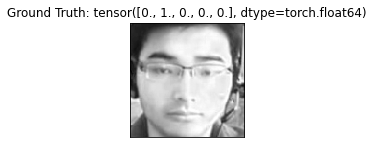

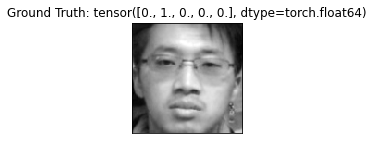

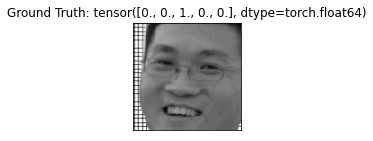

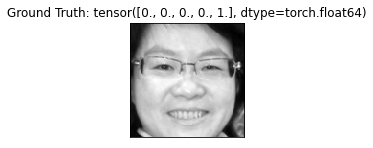

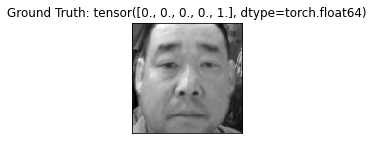

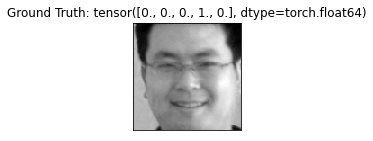

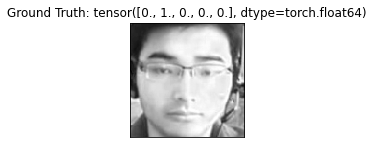

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  plt.show()
fig

## **Building the Network**

In [ ]:
seed=0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
class LeNet(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1   = nn.Linear(32*28*28, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 5)

    def forward(self, x):
        '''
        One forward pass through the network.
        
        Args:
            x: input
        '''
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 32*28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## **Training the Model**

In [ ]:
def train():
    model.train()
    for epoch in range(n_epochs):
      training_loss = 0.0
      val_loss = 0.0
      val_acc = 0
      correct_preds = 0
      correct_train = 0
      best_acc = 0
      validation = 0.0
      total = 0
      total_train_acc = 0

      loop = tqdm(enumerate(train_loader), total = len(train_loader), leave=True)
      
      for batch_idx, (x_imgs, y_labels) in loop:
        x_imgs = x_imgs.to(device)
        y_labels = y_labels.to(device)
        outputs = model(x_imgs)

        _, predicted = torch.max(outputs, 1)
        _, lalabel = torch.max(y_labels.data, 1)
        correct_train += (predicted == lalabel).sum().item()
        total_train_acc += y_labels.size(0)
        
        loss = criterion(outputs.float(), torch.max(y_labels, 1)[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()

      valid_data_loader = tqdm(validation_loader, total=len(validation_loader), leave=True)

      with torch.no_grad():
        model.eval()
        for x_imgs, y_labels in valid_data_loader:
            x_imgs = x_imgs.to(device)
            y_labels = y_labels.to(device)
            outputs = model(x_imgs)

            val_loss = criterion(outputs, torch.max(y_labels, 1)[1])
            validation += val_loss.item()

            total += y_labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            _, lalabel = torch.max(y_labels.data, 1)
            correct_preds += (predicted == lalabel).sum().item()

            torch.save(model.state_dict(), 'model_27_4_64.pth')
            torch.save(optimizer.state_dict(), 'optimizer_27_4_64.pth')

        train_acc = 100 * (correct_train / total_train_acc)
        training_loss /= len(train_loader.dataset)
        validation /= len(validation_loader.dataset)
        val_acc = 100* (correct_preds / total)

        print(f'Epoch: {epoch+1}/{n_epochs}.. Training loss is: {training_loss}.. Validation Loss: {validation}')
        print('Training Accuracy is: {:.2f}%'.format(train_acc))
        print('Validation Accuracy is: {:.2f}%'.format(val_acc))

if __name__ == "__main__":
    train()


100%|██████████| 313/313 [33:48<00:00,  6.48s/it]

Epoch: 1/30.. Training loss is: 0.045170995023846625.. Validation Loss: 0.04417550938129425
Training Accuracy is: 36.01%
Validation Accuracy is: 37.66%



100%|██████████| 313/313 [02:19<00:00,  2.24it/s]

Epoch: 2/30.. Training loss is: 0.04340372987687588.. Validation Loss: 0.04348185505867004
Training Accuracy is: 39.02%
Validation Accuracy is: 39.58%



100%|██████████| 313/313 [02:16<00:00,  2.30it/s]

Epoch: 3/30.. Training loss is: 0.042099758741259576.. Validation Loss: 0.04290449291467666
Training Accuracy is: 41.01%
Validation Accuracy is: 39.73%



100%|██████████| 313/313 [02:18<00:00,  2.27it/s]

Epoch: 4/30.. Training loss is: 0.04066458422541618.. Validation Loss: 0.0425865567445755
Training Accuracy is: 43.43%
Validation Accuracy is: 40.20%



100%|██████████| 313/313 [02:19<00:00,  2.25it/s]

Epoch: 5/30.. Training loss is: 0.039137866163253786.. Validation Loss: 0.04353565036058426
Training Accuracy is: 45.59%
Validation Accuracy is: 39.22%



100%|██████████| 313/313 [02:19<00:00,  2.24it/s]

Epoch: 6/30.. Training loss is: 0.03718016261458397.. Validation Loss: 0.04462242127656937
Training Accuracy is: 48.52%
Validation Accuracy is: 38.45%



100%|██████████| 313/313 [02:21<00:00,  2.22it/s]

Epoch: 7/30.. Training loss is: 0.03493891740739345.. Validation Loss: 0.04674183441400528
Training Accuracy is: 51.81%
Validation Accuracy is: 37.67%



100%|██████████| 313/313 [02:18<00:00,  2.25it/s]

Epoch: 8/30.. Training loss is: 0.03225875776857138.. Validation Loss: 0.0490759259223938
Training Accuracy is: 56.10%
Validation Accuracy is: 38.07%



100%|██████████| 313/313 [02:19<00:00,  2.24it/s]

Epoch: 9/30.. Training loss is: 0.029467135040462018.. Validation Loss: 0.054115892004966734
Training Accuracy is: 59.93%
Validation Accuracy is: 37.76%



100%|██████████| 313/313 [02:18<00:00,  2.26it/s]

Epoch: 10/30.. Training loss is: 0.026793921147286893.. Validation Loss: 0.05706886880397797
Training Accuracy is: 63.71%
Validation Accuracy is: 37.81%



100%|██████████| 313/313 [02:22<00:00,  2.20it/s]

Epoch: 11/30.. Training loss is: 0.02405734975486994.. Validation Loss: 0.06533298420906067
Training Accuracy is: 68.01%
Validation Accuracy is: 37.00%



100%|██████████| 313/313 [02:18<00:00,  2.26it/s]

Epoch: 12/30.. Training loss is: 0.021756511364877225.. Validation Loss: 0.07223977547883988
Training Accuracy is: 71.17%
Validation Accuracy is: 36.91%



100%|██████████| 313/313 [02:18<00:00,  2.26it/s]

Epoch: 13/30.. Training loss is: 0.019681298404932022.. Validation Loss: 0.07970802583694458
Training Accuracy is: 74.25%
Validation Accuracy is: 36.17%



100%|██████████| 313/313 [02:18<00:00,  2.26it/s]

Epoch: 14/30.. Training loss is: 0.01789144909158349.. Validation Loss: 0.08668803870677948
Training Accuracy is: 76.59%
Validation Accuracy is: 36.66%



100%|██████████| 313/313 [02:19<00:00,  2.25it/s]

Epoch: 15/30.. Training loss is: 0.01601521283313632.. Validation Loss: 0.09533451842069626
Training Accuracy is: 79.33%
Validation Accuracy is: 35.68%



100%|██████████| 313/313 [02:19<00:00,  2.24it/s]

Epoch: 16/30.. Training loss is: 0.014817930553480983.. Validation Loss: 0.10643542957305908
Training Accuracy is: 81.20%
Validation Accuracy is: 36.37%



100%|██████████| 313/313 [02:20<00:00,  2.23it/s]

Epoch: 17/30.. Training loss is: 0.013579137998446822.. Validation Loss: 0.11315071716308593
Training Accuracy is: 82.67%
Validation Accuracy is: 35.57%



100%|██████████| 313/313 [02:20<00:00,  2.22it/s]

Epoch: 18/30.. Training loss is: 0.012566042053885758.. Validation Loss: 0.12197781718969346
Training Accuracy is: 84.38%
Validation Accuracy is: 35.27%



100%|██████████| 313/313 [02:20<00:00,  2.23it/s]

Epoch: 19/30.. Training loss is: 0.011896105528064072.. Validation Loss: 0.12122984246015549
Training Accuracy is: 84.94%
Validation Accuracy is: 36.01%



100%|██████████| 313/313 [02:21<00:00,  2.21it/s]

Epoch: 20/30.. Training loss is: 0.010717205084301532.. Validation Loss: 0.14427098231315613
Training Accuracy is: 86.80%
Validation Accuracy is: 35.03%



100%|██████████| 313/313 [02:23<00:00,  2.18it/s]

Epoch: 21/30.. Training loss is: 0.009937682336382567.. Validation Loss: 0.15153658645153045
Training Accuracy is: 87.85%
Validation Accuracy is: 34.48%



100%|██████████| 313/313 [02:21<00:00,  2.22it/s]

Epoch: 22/30.. Training loss is: 0.009607270868774503.. Validation Loss: 0.15068193411827088
Training Accuracy is: 88.28%
Validation Accuracy is: 34.98%



100%|██████████| 313/313 [02:21<00:00,  2.22it/s]

Epoch: 23/30.. Training loss is: 0.008758958345185966.. Validation Loss: 0.1610295407772064
Training Accuracy is: 89.38%
Validation Accuracy is: 35.24%



100%|██████████| 313/313 [02:17<00:00,  2.27it/s]

Epoch: 24/30.. Training loss is: 0.008335887672239915.. Validation Loss: 0.16688639219999313
Training Accuracy is: 89.85%
Validation Accuracy is: 36.51%



100%|██████████| 313/313 [02:24<00:00,  2.17it/s]

Epoch: 25/30.. Training loss is: 0.00802905800519511.. Validation Loss: 0.1762973048567772
Training Accuracy is: 90.50%
Validation Accuracy is: 35.19%



100%|██████████| 313/313 [02:17<00:00,  2.28it/s]

Epoch: 26/30.. Training loss is: 0.007520135641563684.. Validation Loss: 0.17245504114627838
Training Accuracy is: 91.03%
Validation Accuracy is: 34.11%



100%|██████████| 313/313 [02:20<00:00,  2.22it/s]

Epoch: 27/30.. Training loss is: 0.007346149776875973.. Validation Loss: 0.17767212142944336
Training Accuracy is: 91.31%
Validation Accuracy is: 35.18%



100%|██████████| 313/313 [02:18<00:00,  2.27it/s]

Epoch: 28/30.. Training loss is: 0.0069545653407927606.. Validation Loss: 0.18607443883419036
Training Accuracy is: 91.90%
Validation Accuracy is: 34.30%



100%|██████████| 313/313 [02:17<00:00,  2.27it/s]

Epoch: 29/30.. Training loss is: 0.00649707067948766.. Validation Loss: 0.1830882661819458
Training Accuracy is: 92.49%
Validation Accuracy is: 35.52%



100%|██████████| 313/313 [02:17<00:00,  2.28it/s]

Epoch: 30/30.. Training loss is: 0.006472351058758795.. Validation Loss: 0.19213250319957734
Training Accuracy is: 92.59%
Validation Accuracy is: 35.19%


## **If you need to continue to run you use this code.**

In [ ]:
continued_model = LeNet().to(device)
continued_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model_state_dict = torch.load('model_27_4_64.pth')
continued_model.load_state_dict(model_state_dict)

optimizer_state_dict = torch.load('optimizer_27_4_64.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)
continued_model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25088, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [ ]:
def train():
    model.eval()
    for epoch in range(10, 20):
      training_loss = 0.0
      val_loss = 0.0
      val_acc = 0
      correct_preds = 0
      correct_train = 0
      best_acc = 0
      validation = 0.0
      total = 0
      total_train_acc = 0

      loop = tqdm(enumerate(train_loader), total = len(train_loader), leave=True)
      
      for batch_idx, (x_imgs, y_labels) in loop:
        x_imgs = x_imgs.to(device)
        y_labels = y_labels.to(device)
        outputs = model(x_imgs)

        _, predicted = torch.max(outputs, 1)
        _, lalabel = torch.max(y_labels.data, 1)
        correct_train += (predicted == lalabel).sum().item()
        total_train_acc += y_labels.size(0)
        
        loss = criterion(outputs.float(), torch.max(y_labels, 1)[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()

      valid_data_loader = tqdm(validation_loader, total=len(validation_loader), leave=True)

      with torch.no_grad():
        model.eval()
        for x_imgs, y_labels in valid_data_loader:
            x_imgs = x_imgs.to(device)
            y_labels = y_labels.to(device)
            outputs = model(x_imgs)

            val_loss = criterion(outputs, torch.max(y_labels, 1)[1])
            validation += val_loss.item()

            total += y_labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            _, lalabel = torch.max(y_labels.data, 1)
            correct_preds += (predicted == lalabel).sum().item()

            torch.save(model.state_dict(), 'model_24_4_21.pth')
            torch.save(optimizer.state_dict(), 'optimizer_24_4_21.pth')

        train_acc = 100 * (correct_train / total_train_acc)
        training_loss /= len(train_loader.dataset)
        validation /= len(validation_loader.dataset)
        val_acc = 100* (correct_preds / total)

        print(f'Epoch: {epoch+1}/{n_epochs}.. Training loss is: {training_loss}.. Validation Loss: {validation}')
        print('Training Accuracy is: {:.2f}%'.format(train_acc))
        print('Validation Accuracy is: {:.2f}%'.format(val_acc))

if __name__ == "__main__":
    train()


## **Test the model**

In [ ]:
import numpy as np
from misc import progress_bar 

test_loss = 0.0
total     = 0.0
test_correct =0.0

for i, (x_imgs, y_labels) in enumerate(test_loader, 0):
  ### Extract image and labels from trainloader
  x_imgs  = x_imgs.to(device)
  y_labels  = y_labels.to(device)

  outputs = model(x_imgs)

  loss    = criterion(outputs, torch.max(y_labels, 1)[1])
  test_loss += loss.item()

  ### select class index with the maximum value 
  total     += y_labels.size(0)
  _, prediction = torch.max(outputs, 1)
  _, lalabel = torch.max(y_labels, 1)
  
  # correct_preds += (predicted == lalabel).sum().
  test_correct += (prediction==lalabel).sum().item()
  progress_bar(i, len(test_loader), 'Loss: %.4f | Acc: %.3f%% (%d/%d)'
                            % (test_loss / (i + 1), 100. * test_correct / total, test_correct, total))


print('test_loss = '+str(test_loss/len(test_loader.dataset)))
print('test_accuracy = '+ str(test_correct/total))



 292/292 [================================================================================>]  Step: 103ms | Tot: 27s777ms | Loss: 6.0715 | Acc: 34.878% (3259/9344)
test_loss = 0.18973404533956964
test_accuracy = 0.3487799657534247


## **Predict new image for check the accuracy of model**

In [ ]:
with torch.no_grad():
  output = continued_model(example_data.to(device))
  

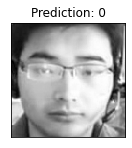

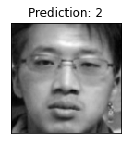

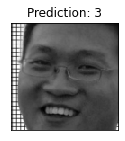

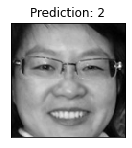

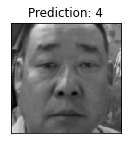

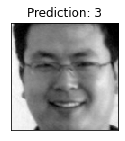

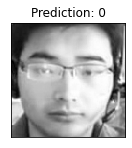

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][1], cmap='gray', interpolation='none')
  plt.title(f'Prediction: {output.data.max(1, keepdim=True)[1][i].item()}')
  plt.xticks([])
  plt.yticks([])
  plt.show()
fig

## **Predict new image**

In [ ]:
transform = transforms.Compose([
        transforms.Resize((120, 120)),
        # transforms.RandomCrop((299,299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

img = Image.open('check_image7.jpg')  # Load image as PIL.Image
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension


output = continued_model(x.to(device=device))  # Forward pass'
pred = torch.argmax(output, 0)  # Get predicted class if multi-class classification
print('Image predicted as ', pred)

Image predicted as  tensor([0, 0, 0, 0, 0], device='cuda:0')
